# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import numpy as np
import lightkurve as lk
import gatspy

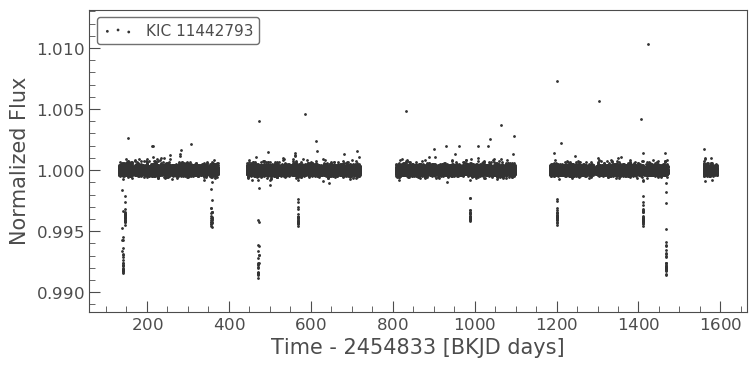

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

In [3]:
clc.time, clc.flux

(array([ 131.51243946,  131.53287376,  131.55330797, ..., 1590.96091289,
        1590.98134703, 1591.00178137]),
 array([0.99988999, 1.00014328, 0.99998635, ..., 1.00004946, 1.00009939,
        1.00003396]))

Best fit period: 331.610 d


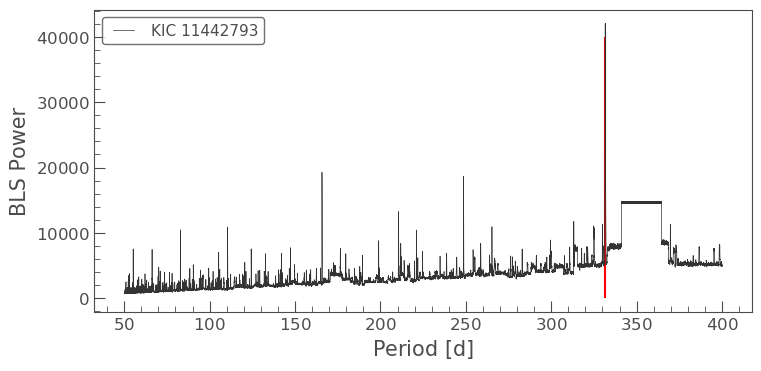

In [4]:
# From the Exoplanet Archive, there are 7 planets of KIC 11442793
# The periodogram
import numpy as np
from gatspy.periodic import LombScargleMultiband
periodogram = clc.to_periodogram(method = 'bls', period = np.arange(50, 400, 0.01))
ax = periodogram.plot()

best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))
fit_period = best_fit_period.value
ax.vlines(fit_period, 0, 40000, color = 'r')

140.4874394588347

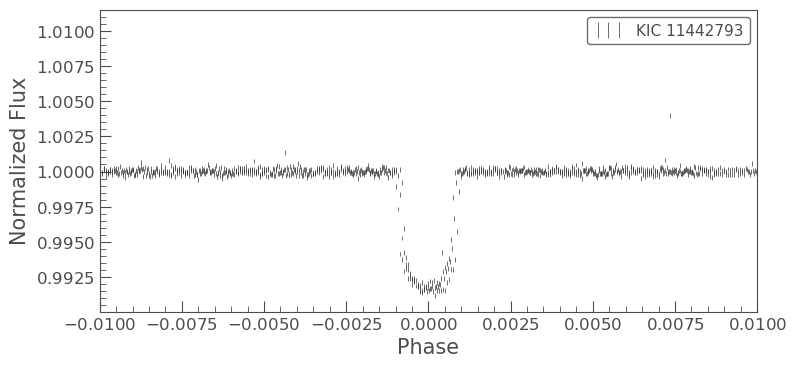

In [5]:
flux1 = clc.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power).errorbar();
t0=periodogram.transit_time_at_max_power
flux1.set_xlim(-0.01, 0.01)
t0

In [6]:
# mask it for transit
# t0 = periodogram.tansit_time_at_max_power
# t = t0 + best_fit_period.value
tmax = np.max(clc.time)

i = 0
t = np.array([])
mask = np.ones(len(clc.time))
while (i*best_fit_period.value + t0) <= tmax:
    tx = i*best_fit_period.value + t0
    t = np.append(t, tx)
    i += 1
    for j in t:
        index = np.abs(clc.time - j).argmin()
        bound = np.arange(index-100, index+100)
        for k in bound:
            if 0 <= k <= len(clc.time):
                mask[k] = 0

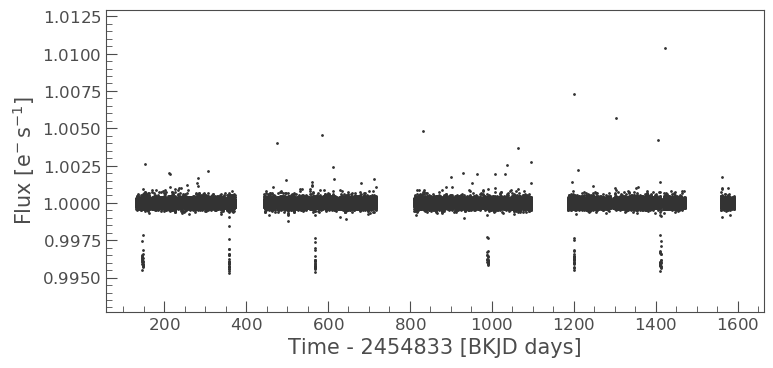

In [7]:
# mask = np.ones(len(clc.time))
# for j in t:
#     index = np.abs(clc.time - j).argmin()
#     bound = np.arange(index-10, index+10)
#     for k in bound:
#         if 0 <= k <= len(clc.time):
#             mask[k] = 0
            
mask = np.array(mask, dtype = 'bool')
time = clc.time[mask]
flux = clc.flux[mask]
error = clc.flux_err[mask]
clc2 = lk.KeplerLightCurve(time, flux, error)
clc2.scatter()

Best fit period: 210.600 d


(-0.01, 0.01)

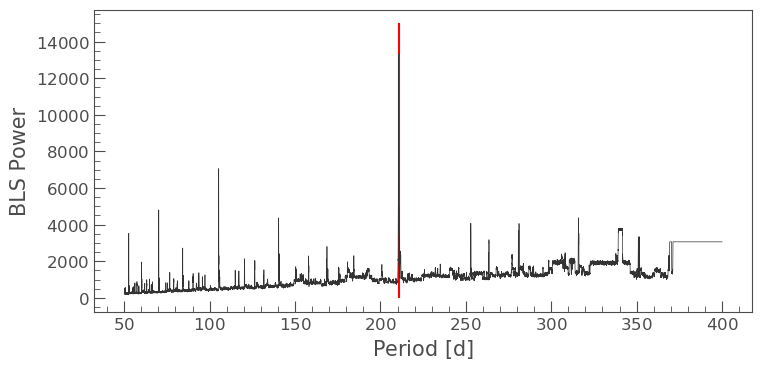

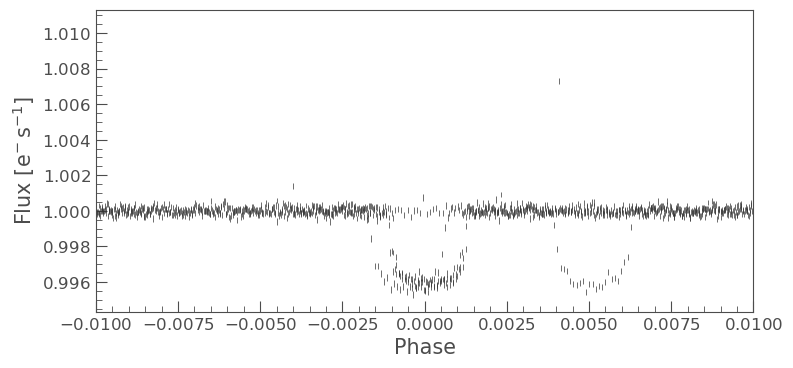

In [8]:
periodogram2 = clc2.to_periodogram(method = 'bls', period = np.arange(50, 400, 0.01))
ax = periodogram2.plot()

best_fit_period = periodogram2.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))
fit_period = best_fit_period.value
ax.vlines(fit_period, 0, 15000, color = 'r')

flux2 = clc2.fold(period=best_fit_period, t0=periodogram2.transit_time_at_max_power).errorbar();
t0=periodogram2.transit_time_at_max_power
flux2.set_xlim(-0.01, 0.01)

In [9]:
t0

147.06243945883472

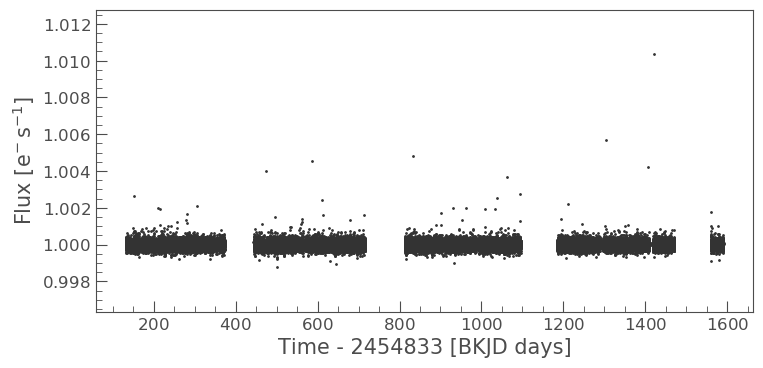

In [10]:
# mask it for transit
tmax = np.max(clc2.time)

i = 0
t = np.array([])
mask = np.ones(len(clc2.time))
while (i*best_fit_period.value + t0) <= tmax:
    tx = i*best_fit_period.value + t0
    t = np.append(t, tx)
    i += 1
    for j in t:
        index = np.abs(clc2.time - j).argmin()
        bound = np.arange(index-100, index+100)
        for k in bound:
            if 0 <= k <= len(clc2.time):
                mask[k] = 0
                
mask = np.array(mask, dtype = 'bool')
time = clc2.time[mask]
flux = clc2.flux[mask]
error = clc2.flux_err[mask]
clc3 = lk.KeplerLightCurve(time, flux, error)
clc3.scatter()

Best fit period: 59.740 d


(-0.01, 0.01)

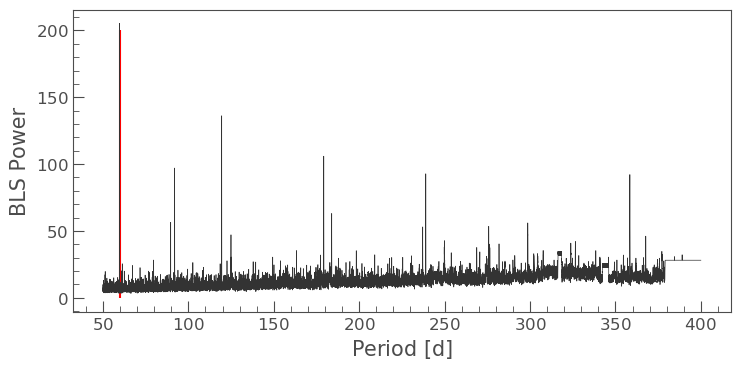

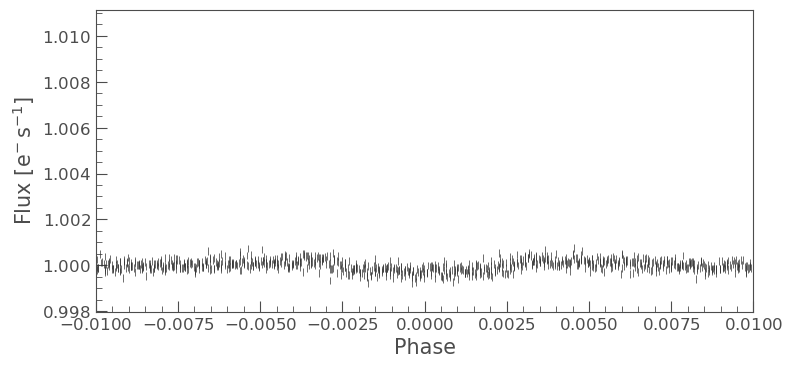

In [11]:
periodogram3 = clc3.to_periodogram(method = 'bls', period = np.arange(50, 400, 0.01))
ax = periodogram3.plot()

best_fit_period = periodogram3.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))
fit_period = best_fit_period.value
ax.vlines(fit_period, 0, 200, color = 'r')

flux3 = clc3.fold(period=best_fit_period, t0=periodogram3.transit_time_at_max_power).errorbar();
t0=periodogram3.transit_time_at_max_power
flux3.set_xlim(-0.01, 0.01)

In [12]:
t0

158.93743945883472

The period and transit epoch of first 3 planets are:  
|Kepler-90h | 331.610 d | 140.4874394588347|  
|Kepler-90g | 210.600 d | 147.06243945883472|  
|Kepler-90d | 59.740 d | 158.93743945883472|  

which match the data from the Exoplanet Archive well.